### Verification of the methods conducted in the paper. Multivariate linear model cv evaluated using consistent metrics.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
from sklearn import linear_model
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from tqdm import tqdm
import seaborn as sns
import pickle
import os
import sys

sys.path.append('../Utils')
from metrics import compute_metrics

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, '../../Data/')

ratios_path = data_dir+'29Atlas/QuantificationTables/Table_EV3/Table_EV3.tsv'
features_path = data_dir+'29Atlas/QuantificationTables/Table_EV6/Table_EV6.tsv'

### Multivariate linear model features (204)
* 61 features for individual codon frequencies(in log2 scale)
* 36 features for Kozak sequence position–nucleotide pairs
* 39 features for stop-codon-context position–nucleotide pairs
* 3 features for CDS, 5' UTR and 3' UTR lengths (in log2 scale)
* 3 features for CDS, 5' UTR and 3' UTR GC percentages, 
* 20 features for 3' UTR motifs
* 25 features for 5' UTR motifs (including upstream AUG)
* 3 features for CDS amino acid motifs
* 6 features for linear protein motifs
* 3 features for 5' UTR folding energy 
* 2 features for codon pair bias
* 1 feature for PEST motifs
* 1 feature for protein isoelectric point
* 1 feature for protein N-terminal hydrophobicity

### Notes
* **The predictive model is a multivariate linear model that predicts tissue-specific PTR log-ratios using tissue-specific coefficients for the sequence features listed in (A)**
* Response: We work on the log10 scale. The median error, i.e. the median of log10(measured PTR) minus log10(predicted PTR), equals log10(3.2). Thus, a prediction is, in median, 3.2-fold away from the measurement. **Response section desribes the median precision as above, but I am pretty sure it should be absolute difference**
* where yij is the tissue-specific PTR ratio (log10)
* (table ev3 -> ratios) Tissue specific mRNA (median across replicates, FPKM-log10), protein (iBAQ-log10) measurements and protein-to-mRNA ratios (log10) of 11,575 transcripts considered in the study. Values that are 0 in natural scale, and FPKM values smaller than 1 in log10 scale are encoded as missing values (NA).
* Verify results using 10 fold cv

In [2]:
ratios = pd.read_csv(ratios_path,sep='\t',index_col=0,usecols=[0]+list(range(62,91)))
features = pd.read_csv(features_path,sep='\t',index_col=0,usecols=[0]+list(range(4,208)))

#### Simple class object used to filter atlas dataset based on tissue

In [3]:
class atlas29():
    def __init__(self,ratios,features):
        """
        Data class to filter ratios and features tables for specific tissues and genes found in that tissue
        """
        assert isinstance(ratios,pd.DataFrame)
        assert isinstance(features,pd.DataFrame)
        
        self.ratios = ratios
        self.features = features
        self.tissues = [name.split('_')[0] for name in ratios.columns]
        
    def filter_tissue(self,tissue_name):
        """
        Function to filter ratios and features for present genes and combine to single dataframe
        """
        assert tissue_name in self.tissues, "Given tissue name is not in data"
        
        genes_present = ~self.ratios[tissue_name+'_PTR'].str.contains('NA')
        ratios_present = self.ratios[[tissue_name+'_PTR']][genes_present].astype(float)
        features = ratios_present.join(self.features)
        return features

#### 10 fold cross validation for each tissue, metrics are generated on held out set

In [4]:
#10 fold CV across all tissues

#Create atlas object to filter on specific tissues
atlas = atlas29(ratios,features)

tissue_metrics = pd.DataFrame()

for tissue in tqdm(atlas.tissues):
    data = atlas.filter_tissue(tissue)
    kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

    cv_results = pd.DataFrame()
    for train_index, test_index in kf.split(data):

        reg_model = linear_model.LinearRegression()

        x_train = data.iloc[train_index,1::]
        y_train = data.iloc[train_index,[0]].values
        
        x_test = data.iloc[test_index,1::]
        #x_test = data.iloc[:,1::]
        y_test = data.iloc[test_index,[0]].values
        #y_test = data.iloc[:,0].values.astype(float)[:,None]

        reg_model.fit(x_train, y_train)
        predicted = reg_model.predict(x_test)
        
        cv_results = cv_results.append(compute_metrics(predicted,y_test,y_train), ignore_index=True)

    mean_cv = cv_results.mean()
    mean_cv.name = tissue
    tissue_metrics = tissue_metrics.append(mean_cv)
    
tissue_metrics.head()

100%|██████████| 29/29 [00:15<00:00,  1.85it/s]


,evs,mae,mean_abs_fc,median_abs_fc,mse,pearsonr,pearsonr_p,r2,smse,spearmanrho,spearmanrho_p
Adrenal,0.237179,0.612323,4.101455,3.261568,0.598193,0.493574,4.698408e-47,0.236601,0.762818,0.489000,4.176063e-44
Appendices,0.185788,0.609765,4.074814,3.140260,0.619791,0.441673,2.370124e-33,0.184138,0.814301,0.434142,2.105397e-31
Brain,0.248708,0.638037,4.348570,3.505606,0.636627,0.499862,1.001758e-45,0.247961,0.751253,0.500599,5.264768e-47
Colon,0.188719,0.596704,3.952712,3.085449,0.583051,0.444536,3.696444e-36,0.187681,0.811094,0.438441,3.059522e-32
Duodenum,0.224095,0.597134,3.957152,3.098240,0.578493,0.485069,1.115548e-44,0.223041,0.775290,0.475008,8.673551e-40


In [5]:
tissue_metrics.mean()

evs              2.173735e-01
mae              6.178954e-01
mean_abs_fc      4.155508e+00
median_abs_fc    3.271747e+00
mse              6.175106e-01
pearsonr         4.747573e-01
pearsonr_p       1.339456e-30
r2               2.161724e-01
smse             7.826095e-01
spearmanrho      4.683981e-01
spearmanrho_p    1.299408e-28
dtype: float64

In [6]:
#tissue_metrics.to_csv('./results/ratios_original_204features.tsv',sep='\t')

#### Testing a single fold model on all of the data for the last tissue from above, graph (even though subset) matches paper figure

In [9]:
#Testing submodel on all the data for last tissue from above
x_full = data.iloc[:,1::]
y_full = data.iloc[:,[0]].values
predicted = reg_model.predict(x_full)

plot = {'predicted':predicted.squeeze(),'truth':y_full.squeeze()}
#plot = {'predicted':10**predicted.squeeze(),'truth':10**y_full.squeeze()}
plot_df = pd.DataFrame.from_dict(plot,orient='index').T
spearmanrho = scipy.stats.spearmanr(y_full,predicted)[0]

Text(0.5, 1.0, 'Predicted vs True Protein Ratios\n in Urinary Bladder Tissue')

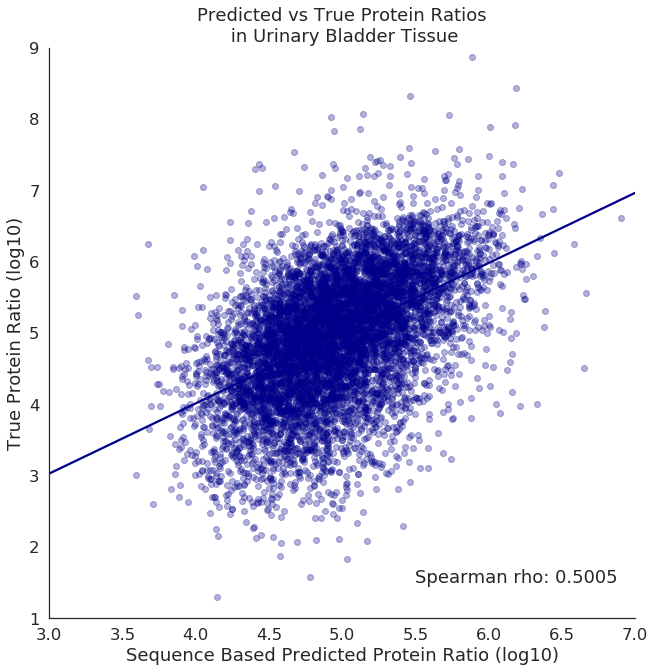

In [10]:
sns.set(style="white", color_codes=True,font_scale=1.5)

fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)
ax.set_xlim(3,7)
# ax.set_xlim(1,9)
ax.set_ylim(1,9)
sns.regplot(x='predicted',y='truth',data=plot_df,ci=None,scatter_kws={'alpha':0.3},color='darkblue',ax=ax)
ax.text(5.5,1.5,f'Spearman rho: {spearmanrho:.4f}')
ax.set_xlabel('Sequence Based Predicted Protein Ratio (log10)')
ax.set_ylabel('True Protein Ratio (log10)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Predicted vs True Protein Ratios\n in Urinary Bladder Tissue')

In [11]:
#fig.savefig('./figures/ratios_original_204features.pdf')